In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'transfer_learn'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import var_ex_X_task, get_model_params, gen_trial_set,gen_trials_from_model_dir,remove_spines
from tools_lnd import make_FP_axs,interp_h_tasks_w_context, get_filename, interp3d
from tools_lnd import gen_D_fp_qr, take_names
from sklearn.decomposition import PCA

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig5','post_transfer_fp')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = str(1)
lr = -7
data_folder = 'data/rnn/multitask/transfer_learn/final/'
post_train = 'delayanti'

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from file: /Us

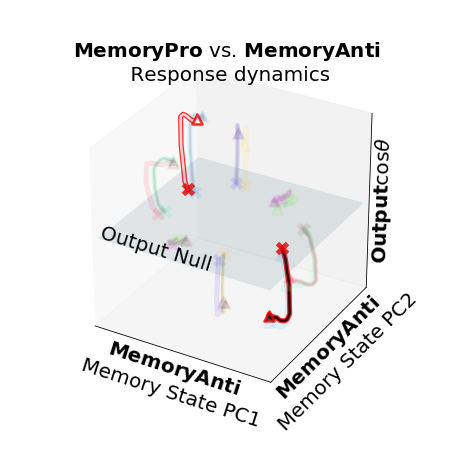

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from file: /Us

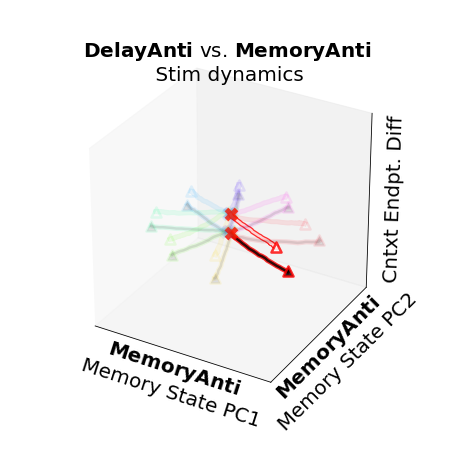

In [11]:
from tools_lnd import gen_trial_set
ruleset = 'mem_anti_motifs'
cmap_discrete = ['w','k']
fig_size = 6

task_set = rules_dict[ruleset]
if ruleset=='all':
    task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
                'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
    task_set.pop(5)
rule_trains_str = '_'.join(task_set)
n_tasks = str(len(task_set))

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
seed = '0'
m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)

rule_set = [2,5]
epoch_set = ['delay1','delay1']
t_set = [0,0]
ri_axs = 1
epoch = epoch_set[ri_axs]
rule = rules_dict['all'][rule_set[ri_axs]]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,0)
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
D_use = make_FP_axs(f, m, rule, epoch, axs = 'pca_h', clust = 'False')
w_in, b_in, w_out, b_out = get_model_params(m)
D_use[:,0] = -D_use[:,0]
D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rule)
ax_labels = {}
ax_labels[0] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1'
ax_labels[1] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2'
ax_labels[2] = r"$\bf{Output}$"+r'$\cos{\theta}$'

interp = False

# interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov_transfer',tol_q = 1e-6,
#          interp = interp,cmap_grad = plt.get_cmap('plasma'),cmap_discrete = cmap_discrete,q_thresh = .000001,
#          n_skip_interps=1, rule_axs = ri_axs, lil_axes =False, plot_unstable = True,
#          plot_zero_plane = True,color_stim = True,fig_size = fig_size, fontsize = 20, figpath = figpath,
#          ruleset = ruleset,ax_labels = ax_labels)

rule_set = [2,5]
epoch_set = ['go1','go1']
t_set = [0,0]

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov_transfer',tol_q = 1e-6,
         interp = interp,cmap_grad = plt.get_cmap('plasma'),cmap_discrete = cmap_discrete,q_thresh = .000001,
         n_skip_interps=1, rule_axs = ri_axs, lil_axes =False, plot_unstable = True,
         plot_zero_plane = True,color_stim = True,fig_size = fig_size, fontsize = 20, figpath = figpath,
         ruleset = ruleset,ax_labels = ax_labels)

trial_set = gen_trial_set(m,[3,5])
D_fp_qr = gen_D_fp_qr(m,trial_set,ri_axs,['fix1','fix1'],t_set)
D_use[:,2] = D_fp_qr[:,0]
ax_labels[2] = 'Cntxt Endpt. Diff'

rule_set = [3,5]
epoch_set = ['stim1','stim1']
t_set = [0,0]

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov_transfer',tol_q = 1e-6,
         interp = interp,cmap_grad = plt.get_cmap('plasma'),cmap_discrete = cmap_discrete,q_thresh = 1e-6,
         n_skip_interps=1, rule_axs = ri_axs, lil_axes =False, plot_unstable = True,
         plot_zero_plane = False,color_stim = True,fig_size = fig_size, fontsize = 20, figpath = figpath,
         ruleset = ruleset,ax_labels = ax_labels)

# D_label = ['N/A','N/A']

# D_use[:,0] = D_use[:,0]
# D_label[0] = r"$\bf{"+'MemoryAnti'+"}$"+' \n '+'memory'+' PC1'

# D_use[:,1] = D_fp_qr[:,0]
# D_label[1] = 'Cntxt Endpt. Diff'

# #eig
# ri_set = [2,5]
# epoch_list = ['go1','go1']
# trial_set = gen_trial_set(m,ri_set)
# interp_h_tasks_w_context(m,ri_set,trial_set,epoch_list,step_file = 'interp_tasks_small_init_mov_transfer',
#                          figpath = figpath,ruleset = ruleset,fig_width = 7,fig_height = 4)
# ri_set = [2,5]
# epoch_list = ['delay1','delay1']
# trial_set = gen_trial_set(m,ri_set)
# interp_h_tasks_w_context(m,ri_set,trial_set,epoch_list,step_file = 'interp_tasks_small_init_mov_transfer',
#                          figpath = figpath,ruleset = ruleset,fig_width = 7,fig_height = 4)
# ri_set = [3,5]
# epoch_list = ['stim1','stim1']
# trial_set = gen_trial_set(m,ri_set)
# interp_h_tasks_w_context(m,ri_set,trial_set,epoch_list,step_file = 'interp_tasks_small_init_mov_transfer',
#                          figpath = figpath,ruleset = ruleset,fig_width = 7,fig_height = 4)


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Docume

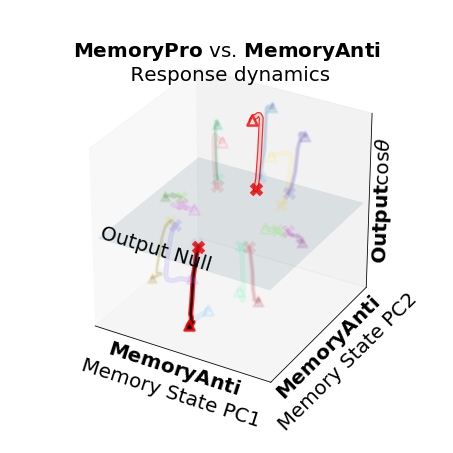

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Docume

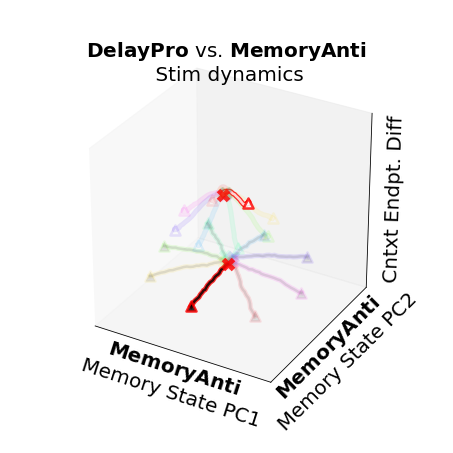

In [12]:
ruleset = 'pro_small'


cmap_discrete = ['w','k']

task_set = rules_dict[ruleset]
if ruleset=='all':
    task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
                'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
    task_set.pop(5)
rule_trains_str = '_'.join(task_set)
n_tasks = str(len(task_set))

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
seed = '1'
m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)

rule_set = [2,5]
epoch_set = ['delay1','delay1']
t_set = [0,0]
ri_axs = 1
epoch = epoch_set[ri_axs]
rule = rules_dict['all'][rule_set[ri_axs]]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,0)
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
D_use = make_FP_axs(f, m, rule, epoch, axs = 'pca_h', clust = 'False')
w_in, b_in, w_out, b_out = get_model_params(m)
D_use[:,0] = -D_use[:,0]
D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rule)
ax_labels = {}
ax_labels[0] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1'
ax_labels[1] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2'
ax_labels[2] = r"$\bf{Output}$"+r'$\cos{\theta}$'

interp = False

# interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov_transfer',tol_q = 1e-6,
#          interp = interp,cmap_grad = plt.get_cmap('plasma'),cmap_discrete = cmap_discrete,q_thresh = .000001,
#          n_skip_interps=1, rule_axs = ri_axs, lil_axes =False, plot_unstable = True,
#          plot_zero_plane = True,color_stim = True,fig_size = fig_size, fontsize = 20, figpath = figpath,
#          ruleset = ruleset,ax_labels = ax_labels)

rule_set = [2,5]
epoch_set = ['go1','go1']
t_set = [0,0]

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov_transfer',tol_q = 1e-6,
         interp = interp,cmap_grad = plt.get_cmap('plasma'),cmap_discrete = cmap_discrete,q_thresh = .000001,
         n_skip_interps=1, rule_axs = ri_axs, lil_axes =False, plot_unstable = True,
         plot_zero_plane = True,color_stim = True,fig_size = fig_size, fontsize = 20, figpath = figpath,
         ruleset = ruleset,ax_labels = ax_labels)

trial_set = gen_trial_set(m,[3,5])
D_fp_qr = gen_D_fp_qr(m,trial_set,ri_axs,['fix1','fix1'],t_set)
D_use[:,2] = D_fp_qr[:,0]
ax_labels[2] = 'Cntxt Endpt. Diff'

rule_set = [0,5]
epoch_set = ['stim1','stim1']
t_set = [0,0]

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov_transfer',tol_q = 1e-6,
         interp = interp,cmap_grad = plt.get_cmap('plasma'),cmap_discrete = cmap_discrete,q_thresh = 1e-6,
         n_skip_interps=1, rule_axs = ri_axs, lil_axes =False, plot_unstable = True,
         plot_zero_plane = False,color_stim = True,fig_size = fig_size, fontsize = 20, figpath = figpath,
         ruleset = ruleset,ax_labels = ax_labels)

# D_label = ['N/A','N/A']

# D_use[:,0] = D_use[:,0]
# D_label[0] = r"$\bf{"+'MemoryAnti'+"}$"+' \n '+'memory'+' PC1'

# D_use[:,1] = D_fp_qr[:,0]
# D_label[1] = 'Cntxt Endpt. Diff'


# #eig
# ri_set = [0,5]
# epoch_list = ['stim1','stim1']
# trial_set = gen_trial_set(m, ri_set)
# interp_h_tasks_w_context(m,ri_set,trial_set,epoch_list,step_file = 'interp_tasks_small_init_mov_transfer',
#                          figpath = figpath,ruleset = ruleset,fig_width = 7,fig_height = 4)
# ri_set = [2,5]
# epoch_list = ['delay1','delay1']
# trial_set = gen_trial_set(m, ri_set)
# interp_h_tasks_w_context(m,ri_set,trial_set,epoch_list,step_file = 'interp_tasks_small_init_mov_transfer',
#                          figpath = figpath,ruleset = ruleset,fig_width = 7,fig_height = 4)
# ri_set = [2,5]
# epoch_list = ['go1','go1']
# trial_set = gen_trial_set(m, ri_set)
# interp_h_tasks_w_context(m,ri_set,trial_set,epoch_list,step_file = 'interp_tasks_small_init_mov_transfer',
#                          figpath = figpath,ruleset = ruleset,fig_width = 7,fig_height = 4)


In [13]:
lim_max = .000001
lim_min = .00000001

ylim_spread = lim_max-lim_min

while ylim_spread<1:
    lim_max = lim_max+1.5*ylim_spread
    lim_min = lim_min-1.5*ylim_spread
    ylim_spread = lim_max-lim_min

In [8]:
from tools_lnd import take_names, gen_trials_from_model_dir, gen_X_from_model_dir_epoch

def var_ex_X_task(ax, m, rule_set, epoch_set, n_components = 200, batch_size = 1000, plot_legend = False):

    rule_name_set = {}
    _, rule_name_set[0], _, _ = take_names(epoch_set[0],rule_set[0])
    _, rule_name_set[1], _, _ = take_names(epoch_set[1],rule_set[1])

    trial = gen_trials_from_model_dir(m,rule_set[0],mode='random',noise_on = False,batch_size = 200)
    X, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[0])
    pca = PCA(n_components = n_components)
    _ = pca.fit_transform(X.T)

    trial = gen_trials_from_model_dir(m,rule_set[1],mode='random',noise_on = False,batch_size = 200)
    X_ax, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[1])
    pca_ax = PCA(n_components = n_components)
    _ = pca_ax.fit_transform(X_ax.T)

    var_same = np.var(np.dot(pca.components_,X),axis = 1)
    var_ax = np.var(np.dot(pca_ax.components_,X),axis = 1)

    plt.rcParams.update({'font.size': 16})
    plt.plot(np.cumsum(var_same)/np.sum(var_same),'-ok',linewidth = 3,markersize = 10,alpha = .5,
             label = rule_name_set[0] + ' PCs')
    plt.plot(np.cumsum(var_ax)/np.sum(var_same),'-o',c = 'mediumorchid', linewidth = 3,markersize = 10,
             alpha = .5,label = rule_name_set[1] + ' PCs')
    plt.xlabel('N PCs',fontsize = 18)
    ax.xaxis.set_label_coords(.15, -0.025)
    plt.ylabel(rule_name_set[0] +'\n Variance Explained',fontsize = 18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([n_components,])
    ax.set_ylim([0,1.1])
    ax.set_xlim([-.05*n_components,2.5*n_components])
    if plot_legend==True:
        plt.legend(loc='upper center', bbox_to_anchor=(0.01, 1.3))

stim1
stim1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored fr

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/3/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/3/model.ckpt
Model restored from file: /Us

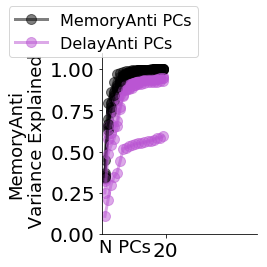

delay1
delay1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored 

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/3/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/3/model.ckpt
Model restored from file: /Us

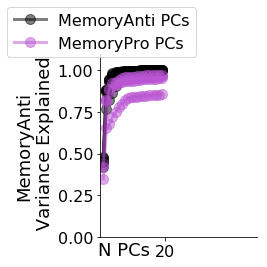

go1
go1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/0/model.ckpt
Model restored from f

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/3/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/mem_anti_motifs/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_fdanti/post_train_delayanti/3/model.ckpt
Model restored from file: /Us

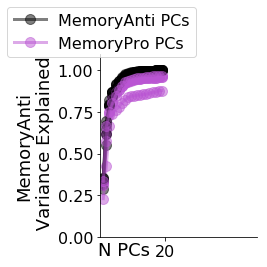

In [9]:
ruleset = 'mem_anti_motifs'

task_set = rules_dict[ruleset]
if ruleset=='all':
    task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
                'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
    task_set.pop(5)
rule_trains_str = '_'.join(task_set)
n_tasks = str(len(task_set))

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(1,1,1)
for seed_ind in range(5):
    seed=str(seed_ind)
    m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)
        
    ri_set = [5,3]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    epoch_set = ['stim1','stim1']
    
    if seed=='0':
        plot_legend = True
    else:
        plot_legend = False
        
    var_ex_X_task(ax, m, rule_set, epoch_set, n_components = 20, plot_legend = plot_legend)

figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

fig_fldr = os.path.join(figpath,'var',ruleset)
if not os.path.exists(fig_fldr):
    os.makedirs(fig_fldr)
        
plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
plt.savefig(os.path.join(fig_fldr,figname+'.png'),bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(1,1,1)
for seed_ind in range(5):
    seed=str(seed_ind)
    m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)
      
    ri_set = [5,2]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    epoch_set = ['delay1','delay1']
    
    if seed=='0':
        plot_legend = True
    else:
        plot_legend = False
    
    var_ex_X_task(ax, m, rule_set, epoch_set, n_components = 20, plot_legend = plot_legend)
    
figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

fig_fldr = os.path.join(figpath,'var',ruleset)
if not os.path.exists(fig_fldr):
    os.makedirs(fig_fldr)
        
plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
plt.savefig(os.path.join(fig_fldr,figname+'.png'),bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(1,1,1)
for seed_ind in range(5):
    seed=str(seed_ind)
    m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)
      
    ri_set = [5,2]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    epoch_set = ['go1','go1']
    
    if seed=='0':
        plot_legend = True
    else:
        plot_legend = False
    
    var_ex_X_task(ax, m, rule_set, epoch_set,plot_legend = plot_legend, n_components = 20)
    
figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

fig_fldr = os.path.join(figpath,'var',ruleset)
if not os.path.exists(fig_fldr):
    os.makedirs(fig_fldr)
        
plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
plt.savefig(os.path.join(fig_fldr,figname+'.png'),bbox_inches = 'tight')
plt.show()

TypeError: var_ex_X_task() takes at least 4 arguments (5 given)

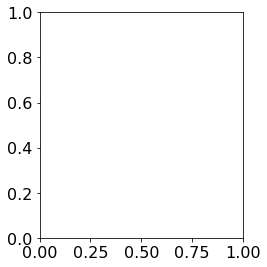

In [10]:
ruleset = 'pro_small'

task_set = rules_dict[ruleset]
if ruleset=='all':
    task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
                'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
    task_set.pop(5)
rule_trains_str = '_'.join(task_set)
n_tasks = str(len(task_set))

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(1,1,1)
for seed_ind in range(4):
    seed=str(seed_ind)
    m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)
        
    ri_set = [5,0]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    epoch_set = ['stim1','stim1']
    
    if seed=='0':
        plot_legend = True
    else:
        plot_legend = False
        
    var_ex_X_task(m, rule_set, epoch_set,plot_legend = plot_legend, n_components = 20)

figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

fig_fldr = os.path.join(figpath,'var',ruleset)
if not os.path.exists(fig_fldr):
    os.makedirs(fig_fldr)
        
plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
plt.savefig(os.path.join(fig_fldr,figname+'.png'),bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(1,1,1)
for seed_ind in range(4):
    seed=str(seed_ind)
    m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)
      
    ri_set = [5,2]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    epoch_set = ['delay1','delay1']
    
    if seed=='0':
        plot_legend = True
    else:
        plot_legend = False
    
    var_ex_X_task(m, rule_set, epoch_set,plot_legend = plot_legend, n_components = 20)
    
figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

fig_fldr = os.path.join(figpath,'var',ruleset)
if not os.path.exists(fig_fldr):
    os.makedirs(fig_fldr)
        
plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
plt.savefig(os.path.join(fig_fldr,figname+'.png'),bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(1,1,1)
for seed_ind in range(4):
    seed=str(seed_ind)
    m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)
      
    ri_set = [5,2]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    epoch_set = ['go1','go1']
    
    if seed=='0':
        plot_legend = True
    else:
        plot_legend = False
    
    var_ex_X_task(m, rule_set, epoch_set,plot_legend = plot_legend, n_components = 20)
    
figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

fig_fldr = os.path.join(figpath,'var',ruleset)
if not os.path.exists(fig_fldr):
    os.makedirs(fig_fldr)
        
plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
plt.savefig(os.path.join(fig_fldr,figname+'.png'),bbox_inches = 'tight')
plt.show()